#### Code

In [1]:
from numba import jit, cuda
import warnings
import cv2
import numpy as np
import math
import random
import time as timess
from prettytable import PrettyTable
from IPython.display import clear_output, Markdown, display
base_noise_min=-0.005
base_noise_max= 0.005

ci=0#len(time)//4
cf=10000

fig_x , fig_y = 25 , 2
clrs= 'rgbcmyk'

In [2]:
# rf = open("Radar_G_table.txt", "w")
# f = open("G_table.txt", "w")
# for j in range(5,185,5):
#     f.write(str(j/10))
#     f.write(' | ')
#     rf.write(str(j/10))
#     rf.write(' | ')
#     for i in range(360):
#         if((i>=0 and i<=90) or (i>=270 and i<360)):
#             f.write(str(math.cos(math.radians(i)))+' ')
#             rf.write(str(math.cos(math.radians(i)))+' ')
#         else:
#             f.write(str(0)+' ')
#             rf.write(str(0)+' ')
#     f.write('\n')
#     rf.write('\n')
# f.close()    
# rf.close()    

G_table={}
f = open("G_table.txt", "r")
Lines = f.readlines()
for line in Lines:
    tmp=list(line.split())
    tmp_freq=float(tmp[0])
    tmp=tmp[2:]
    G_table[tmp_freq]=[]
    for i in tmp:
        G_table[tmp_freq].append(float(i))
f.close()

Radar_G_table={}
f = open("Radar_G_table.txt", "r")
Lines = f.readlines()
for line in Lines:
    tmp=list(line.split())
    tmp_freq=float(tmp[0])
    tmp=tmp[2:]
    Radar_G_table[tmp_freq]=[]
    for i in tmp:
        Radar_G_table[tmp_freq].append(float(i))
f.close()

In [3]:
class radar:
    def __init__(self, id,pri=500,pwd=10,pos=(0,0),heading=0,radarWaypoints=[]):
        self.id = id                                       # Id of the radar
        self.pri = pri                                     # Pulse Repetition Interval 1 nano seconds
        self.pwd = pwd                                     # Pulse Width in 1 nano seconds
        self.Pt = (10**6)*1                                # Peak transmitted power
        self.freq = 10.0                                   # frequency range 0.5 to 18 units gigahertz
        self.heading = heading                             # heading of the radar in degrees
        self.impedance = 50
        self.pos = radarWaypoints[0]
        self.speed=10
        self.radarWaypoints=radarWaypoints
        self.nxt=1
    def move_radar(self):
        if(len(self.radarWaypoints)>1):
            time_diff=1
            cur_pos=list(self.pos)
            nxt=self.nxt
            d=math.dist(self.radarWaypoints[nxt],cur_pos)
            idx=0
            while(d < (self.speed*time_diff)):
                idx += 1
                nxt += 1
                if (nxt== len(self.radarWaypoints)):
                    nxt = 0
                if(idx>len(self.radarWaypoints)*2):
                    raise Exception("Radar "+self.id+"'s speed is too much")
                d=math.dist(self.radarWaypoints[nxt],cur_pos)
            heading=math.degrees(math.atan2(self.radarWaypoints[nxt][1] - cur_pos[1],self.radarWaypoints[nxt][0] - cur_pos[0]))
            while(heading>=360):
                heading-=360
            while(heading<0):
                heading+=360
            self.heading=heading
            cur_pos[0] += ((self.speed * time_diff) * (self.radarWaypoints[nxt][0] - cur_pos[0]) / d)
            cur_pos[1] += ((self.speed * time_diff) * (self.radarWaypoints[nxt][1] - cur_pos[1]) / d)
            self.pos=cur_pos
            self.nxt=nxt
    def __del__(self):
        pass
class aircraft:
    def __init__(self, id,pos=(0,0),heading=0,receivers=4,aircraftWaypoints=[]):
        self.id = id                                       # Id of the Aircraft
        self.pos = aircraftWaypoints[0]                    # Position of the radar
        self.heading = heading                             # heading of the Aircraft in degrees
        self.receivers_n = receivers                       # Number of antenna's in the RWR
        self.speed=10
        self.aircraftWaypoints=aircraftWaypoints
        self.nxt=1
    def move_aircraft(self):
        if(len(self.aircraftWaypoints)>1):
            time_diff=1
            cur_pos=list(self.pos)
            nxt=self.nxt
            d=math.dist(self.aircraftWaypoints[nxt],cur_pos)
            idx=0
            while(d < (self.speed*time_diff)):
                idx += 1
                nxt += 1
                if (nxt== len(self.aircraftWaypoints)):
                    nxt = 0
                if(idx>len(self.aircraftWaypoints)*2):
                    raise Exception("Aircraft speed is too much")
                d=math.dist(self.aircraftWaypoints[nxt],cur_pos)
            heading=math.degrees(math.atan2(self.aircraftWaypoints[nxt][1] - cur_pos[1],self.aircraftWaypoints[nxt][0] - cur_pos[0]))
            while(heading>=360):
                heading-=360
            while(heading<0):
                heading+=360
            self.heading=heading
            cur_pos[0] += ((self.speed * time_diff) * (self.aircraftWaypoints[nxt][0] - cur_pos[0]) / d)
            cur_pos[1] += ((self.speed * time_diff) * (self.aircraftWaypoints[nxt][1] - cur_pos[1]) / d)
            self.pos=cur_pos
            self.nxt=nxt
    
    def __del__(self):
        pass
    

In [12]:
def signal_generator(radar,aircraft,i):
    global G_table,base_noise_min,base_noise_max,time,receivers_n,rwr_antenna_n
    pri = radar.pri                               # Pulse Repetition Interval
    pwd = radar.pwd                               # Pulse Width
    R = math.dist(radar.pos,aircraft.pos)         # Distance between the radar and the aircraft
    Pt = radar.Pt                                 # Peak transmitted power
    freq = radar.freq                             # carrier frequency
    # Lambda=3*(10**8)/radar.freq
    Lambda=2
    angle=math.degrees(math.atan2(radar.pos[1]-aircraft.pos[1],radar.pos[0]-aircraft.pos[0]))-aircraft.heading
    while(angle>=360):
        angle-=360                                     # Angle between the aircraft's front direction and radar
    while(angle<0):
        angle+=360
    angle_rad = radar.heading
    angle_t=int(angle-angle_rad-180-(360-aircraft.heading))
    while(angle_t>=360):
        angle_t-=360                                     # Angle between the radar's boresight and aircraft
    while(angle_t<0):
        angle_t+=360
    angle_radar = angle_t
    P=(Pt*Radar_G_table[freq][angle_t]*(Lambda**2))/((4*math.pi*R)**2)  # Power recieved by the aircraft radar reciver
    a=0.1
    omega=2*np.pi*18/10
    angl_cond=[]
    loss=8
    pulse_train_angles=[]
    pulse_train_frequency=[]
    pulse_train=[]                                   # we are producing the pulse train for the 4 recievers
    for j in range(receivers_n):                          # front left, rear left, rear right and front right respectively
        angl_cond.append((360/receivers_n)*(1+2*j)/2)     # based on the above information
        pulse_train.append([])
    for j in range(rwr_antenna_n-receivers_n):
        pulse_train.append([])
    # for i in range(-1,len(time)-1):
    if(i%pri<=pwd):
        pulse_train_angles.append(angle)
        pulse_train_frequency.append(freq)
        idx=0
        for j in pulse_train:
            tmp_n=random.uniform(base_noise_min,base_noise_max)
            tmp_v=math.sqrt(abs(P*G_table[freq][int(angle-angl_cond[idx])])*radar.impedance)
            j.append(tmp_n if tmp_v<base_noise_max else tmp_v*(1+a*(np.sin(omega*i)-1)))
            idx+=1
    else:
        pulse_train_angles.append(0)
        pulse_train_frequency.append(0)
        for j in pulse_train:
            j.append(random.uniform(base_noise_min,base_noise_max))
    return pulse_train,pulse_train_angles,pulse_train_frequency

In [32]:
rwr_antenna_n = 4              # Number of recievers on the aircraft(4 or 6)
radars_n = 3                   # Number of radars

img = np.zeros((700,1400,3), np.uint8)

radar_positions=[]
rad_range=[1,2,3,4]
rad_range_x=[0,img.shape[1]//2-img.shape[1]//7,img.shape[1]//2+img.shape[1]//7,img.shape[1]]
rad_range_y=[0,img.shape[0]//2-img.shape[0]//7,img.shape[0]//2+img.shape[0]//7,img.shape[0]]
for i in range(radars_n):
    radar_positions.append((random.uniform(rad_range_x[0],rad_range_x[1]) if random.uniform(-1,1)>0 else random.uniform(rad_range_x[2],rad_range_x[3]),
                            random.uniform(rad_range_y[0],rad_range_y[1]) if random.uniform(-1,1)>0 else random.uniform(rad_range_y[2],rad_range_y[3])))
radar_positions = np.array(radar_positions)

# radar_positions = np.array([
#     # (1,0),
#     (300,150),
#     # (1,0.2),
#     (100,600),
#     # (-1,1),
#     (600,600),
#     # (-1,-1),
#     # (0,-1),
#     # (1,-1),
# ])
radar_positions = np.array([
                            (655.0, 466.0), 
                            (39.0, 500.0), 
                            (50.0, 42.0), 
                            (1355.0, 670.0),
                           ])
# tmp=[(93.0, 506.0), (87.0, 375.0), (257.0, 371.0), (393.0, 365.0), (410.0, 502.0), (420.0, 610.0), (270.0, 624.0), (119.0, 628.0)]
radar_waypoints = [[]]*len(radar_positions)
radar_waypoints = list([[radar_positions[0]]+[(829, 384), (505, 383)]
                       ,[radar_positions[1]]
                       # ,[radar_positions[2]]
                       # ,[radar_positions[3]]
                       ])
radars_n=len(radar_waypoints)
receivers_n = 4 # Effective number of antenna

aircraft_waypoints = [(221, 469), (216, 174), (1237, 160), (1237, 478), (682, 650)]
aircraft_0 = aircraft(id=0,heading=random.uniform(0,360),receivers=receivers_n,aircraftWaypoints=aircraft_waypoints)
# aircraft_0 = aircraft(id=0,heading=0,receivers=receivers_n,aircraftWaypoints=aircraft_waypoints)
radars=[]
pulses=[]                         
for i in range(rwr_antenna_n+1):                          
    pulses.append([])
pris=[400,550,750]
for j in range(radars_n):
    heading_angle=int(math.degrees(math.atan2(aircraft_0.pos[1]-radar_positions[j][1],aircraft_0.pos[0]-radar_positions[j][0])))#+180
    heading_noise_range=0
    # rand_pri=int(np.random.normal(loc=150, scale=70000, size=(1))[0])
    rand_pri=int(random.uniform(100,1000))
    # radar_j = radar(id=j,pri=rand_pri,pwd=15,pos=radar_positions[j],heading=random.randint(heading_angle-heading_noise_range,heading_angle+heading_noise_range),radarWaypoints=radar_waypoints[j])
    radar_j = radar(id=j,pri=pris[j],pwd=15,pos=radar_positions[j],heading=random.randint(heading_angle-heading_noise_range,heading_angle+heading_noise_range),radarWaypoints=radar_waypoints[j])
    rand_freq=(int(random.uniform(0,18)))
    radar_j.freq=0.5+rand_freq
    radars.append(radar_j)
    del radar_j;
print('Aircraft and it\'s description')
t = PrettyTable(['Id','Number of RWR antenna\'s'])
i=aircraft_0
t.add_row([i.id+1,i.receivers_n])
print(t)
print('Radars and their description')
t = PrettyTable(['Id', 'Peak transmitted power','frequency','Pulse Repetition Interval','Pulse Width'])
for i in radars:
    t.add_row([i.id+1,"{:.2e}".format(i.Pt),i.freq,i.pri,i.pwd])
print(t)

Aircraft and it's description
+----+-------------------------+
| Id | Number of RWR antenna's |
+----+-------------------------+
| 1  |            4            |
+----+-------------------------+
Radars and their description
+----+------------------------+-----------+---------------------------+-------------+
| Id | Peak transmitted power | frequency | Pulse Repetition Interval | Pulse Width |
+----+------------------------+-----------+---------------------------+-------------+
| 1  |        1.00e+06        |    17.5   |            400            |      15     |
| 2  |        1.00e+06        |    10.5   |            550            |      15     |
+----+------------------------+-----------+---------------------------+-------------+


In [33]:
tmp_s_r=20
tmp_s_a=20
aircraft_0.speed=2
for i in radars:
    i.speed=1
time = 10**4 #in nano seconds 


frame = np.zeros((500,1000,3), np.uint8)
pulse_train_angles=[]
pulse_train_frequency=[]
pulse_train=[]
pulse_train_f=[]
for j in range(rwr_antenna_n):
    pulse_train.append([])
    for i in range(len(radars)):
        pulse_train[-1].append([])
    pulse_train_f.append([])
mov_offset=0


tmp_pdw={}
pdw=[]
counter=[]
max_amplitude=[]
list_init=[]
fall_flag=[]
lead_flag=[]
increasing_count=[]
increasing_flag=[]
top_points=[]
for j in range(rwr_antenna_n):
    counter.append(0)
    max_amplitude.append(0)
    increasing_count.append(0)
    list_init.append([])
    top_points.append([])
    increasing_flag.append(0)
    fall_flag.append(True)
    lead_flag.append(True)

idx=0
play_flag=True
visualize=False
while idx<time:
# for idx in range(60):
    # in_tim=timess.time()
    if(play_flag):
        if(0):
            if(idx%10==0):
                aircraft_0.move_aircraft()
                for i in radars:
                    i.move_radar()


        if(visualize):
            img = np.zeros(img.shape, np.uint8)
            airc_pos=(int(aircraft_0.pos[0]),int(aircraft_0.pos[1]))
            for j in range(receivers_n):
                cv2.line(img, airc_pos, 
                         (int(airc_pos[0]+(tmp_s_a*math.cos(math.radians(aircraft_0.heading+(360/receivers_n)*(1+2*j)/2)))),
                          int(airc_pos[1]+(tmp_s_a*math.sin(math.radians(aircraft_0.heading+(360/receivers_n)*(1+2*j)/2))))), (0,0,255), 2)
            cv2.circle(img, airc_pos, 5, (0,255,0), -1)
            airc_head=(int(airc_pos[0]+(tmp_s_a*1.5*math.cos(math.radians(aircraft_0.heading)))),int(airc_pos[1]+(tmp_s_a*math.sin(math.radians(aircraft_0.heading)))))
            cv2.line(img, airc_pos, airc_head, (0,255,0), 2)

        max_t=[]
        max_t_a=set()
        max_t_f=set()
        for j in range(rwr_antenna_n):
            max_t.append([])
        for j in range(len(radars)):
            # radar_pos=(int(img.shape[1]//2+radars[i].pos[0]),int(img.shape[0]//2+radars[i].pos[1]))
            radar_pos=(int(radars[j].pos[0]),int(radars[j].pos[1]))
            heading_angle=int(math.degrees(math.atan2(airc_pos[1]-radar_pos[1],airc_pos[0]-radar_pos[0])))#+180
            heading_noise_range=0
            radars[j].heading=heading_angle#random.randint(heading_angle-heading_noise_range,heading_angle+heading_noise_range)
            pulse_train_r,pulse_train_angles_r,pulse_train_frequency_r=signal_generator(radars[j],aircraft_0,idx)
            for k in range(len(pulse_train_r)):
                max_t[k].append(pulse_train_r[k][0])
                pulse_train[k][j].append(pulse_train_r[k][0])
            if(pulse_train_angles_r[0]!=0):
                max_t_a.add(pulse_train_angles_r[0])
            if(pulse_train_frequency_r[0]!=0):
                max_t_f.add(pulse_train_frequency_r[0])


            if(visualize):
                cv2.circle(img, radar_pos, 5, (255,0,0), -1)
                cv2.line(img, radar_pos, 
                         (int(radar_pos[0]+(tmp_s_r*math.cos(math.radians(radars[j].heading)))),
                          int(radar_pos[1]+(tmp_s_r*math.sin(math.radians(radars[j].heading))))), (0,0,255), 2) 


        all_fall=0
        tmp_counter=[]
        tmp_amplitude=[]

        if(idx>=frame.shape[1]-1):
        # if(i-mov_offset>200):
            off_spd=1
            mov_offset+=off_spd
            tmp=frame[:,off_spd:,:].copy()
            frame[:,:-off_spd,:]=tmp.copy()

        if(len(max_t_a)==1):
            pulse_train_angles.append(list(max_t_a)[0])
        else:
            pulse_train_angles.append(0)
        if(len(max_t_a)==1):
            pulse_train_frequency.append(list(max_t_f)[0])
        else:
            pulse_train_frequency.append(0)
        for j in range(len(max_t)):
            pulse_train_f[j].append(max(max_t[j]))
            if(idx>0):
                if(visualize):
                    cv2.line(frame,
                             (idx-mov_offset,frame.shape[0]*(j+1)//4-int(pulse_train_f[j][idx-1]*10)-10),
                             (idx-mov_offset,frame.shape[0]*(j+1)//4-int(pulse_train_f[j][idx]*10)-10),
                             (0,0,255),1)
            if(pulse_train_f[j][-1]>base_noise_max):
                if not(lead_flag[j]):
                    lead_flag[j]=True # Rising edge
                    if(len(tmp_pdw)==0):
                        tmp_pdw['TOA (100 pico seconds)']=idx
                if(pulse_train_f[j][-1]>max_amplitude[j]):
                    max_amplitude[j]=pulse_train_f[j][-1]
                counter[j]+=1
                fall_flag[j]=False
            else:
                if not(fall_flag[j]):
                    fall_flag[j]=True # Falling edge
                    tmp_counter.append(counter[j])
                tmp_amplitude.append(max_amplitude[j])
                lead_flag[j]=False
                max_amplitude[j]=0
                counter[j]=0
                all_fall+=1
        if(all_fall==len(max_t) and len(tmp_pdw)!=0):
            round_digits=4
            tmp_pdw['TOA with error']=tmp_pdw['TOA (100 pico seconds)']+int(random.uniform(-10,10))
            tmp_pdw['PWD (100 pico seconds)']=max(tmp_counter)-1
            tmp_pdw['Frequency (GHz)']=round(max(pulse_train_frequency[tmp_pdw['TOA (100 pico seconds)']:tmp_pdw['TOA (100 pico seconds)']+tmp_pdw['PWD (100 pico seconds)']]),2)
            tmp_pdw['Frequency with error']=round(tmp_pdw['Frequency (GHz)']+random.uniform(-0.3,0.3),4)
            tmp_pdw['Amplitude (Volts)']=[]
            tmp_pdw['AOA (Degrees)']=round(max(pulse_train_angles[tmp_pdw['TOA (100 pico seconds)']:tmp_pdw['TOA (100 pico seconds)']+tmp_pdw['PWD (100 pico seconds)']]),4)
            tmp_pdw['Freq_modulation_flag']=0
            freq_app=True
            freq_mod=False
            Freq=0
            for j in range(len(max_t)):
                if(len(max_t)>4):
                    if(j==0 or j==1):
                        if(j==0):
                            tmp_pdw['Amplitude (Volts)'].append([])
                        tmp_pdw['Amplitude (Volts)'][-1].append(round(tmp_amplitude[j],round_digits))
                    elif(j==4 or j==5):
                        if(j==4):
                            tmp_pdw['Amplitude (Volts)'].append([])
                        tmp_pdw['Amplitude (Volts)'][-1].append(round(tmp_amplitude[j],round_digits))
                    else:
                        tmp_pdw['Amplitude (Volts)'].append(round(tmp_amplitude[j],round_digits))
                else:
                    tmp_pdw['Amplitude (Volts)'].append(round(tmp_amplitude[j],round_digits))
            tmp_pdw['Freq_modulation_flag']=False
            pdw.append(tmp_pdw)
            tmp_pdw={}
        idx+=1
        # print(max_t)
        # print(pulse_train_f)

        if(visualize):
            image = cv2.putText(img,'Time in nano seconds : '+str(idx//10),(img.shape[1]*6//10,img.shape[0]*1//10),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),1,cv2.LINE_AA)
    if(visualize):
        cv2.imshow('Visualisation',img)
        cv2.imshow('Test', frame)
        # cv2.waitKey(0)
        # break
        quit_k = cv2.waitKey(1) & 0xFF
        if quit_k == ord('q'):
            break
        if quit_k == ord('p'):
            play_flag=False
        if quit_k == ord('l'):
            play_flag=True
    # print(timess.time()-in_tim) #clock resolution
    if not (visualize):
        if(idx%100==0):
            print(idx/time)
            clear_output(wait=True)
if(visualize):
    cv2.imwrite('Visualisation.jpg',img)
    cv2.destroyAllWindows()

1.0


In [34]:
if(len(pdw)>1):
    display(Markdown('{}<strong>{}</strong>{}'.format('PDW\'s of the recieved pulses in ',str(idx//10)+' nano seconds',' are as follows')))
    t = PrettyTable(list(pdw[0].keys()))
    for i in pdw[:]:
        t.add_row(list(i.values()))
    print(t)

PDW's of the recieved pulses in <strong>1000 nano seconds</strong> are as follows

+------------------------+----------------+------------------------+-----------------+----------------------+----------------------------------+---------------+----------------------+
| TOA (100 pico seconds) | TOA with error | PWD (100 pico seconds) | Frequency (GHz) | Frequency with error |        Amplitude (Volts)         | AOA (Degrees) | Freq_modulation_flag |
+------------------------+----------------+------------------------+-----------------+----------------------+----------------------------------+---------------+----------------------+
|          400           |      395       |           15           |       17.5      |       17.6084        |      [0, 1.8782, 2.3888, 0]      |    193.3928   |        False         |
|          550           |      544       |           15           |       10.5      |       10.3044        |      [5.3091, 0, 0, 4.8632]      |     4.1224    |        False         |
|          800           |      809       |           15           |       17.5 

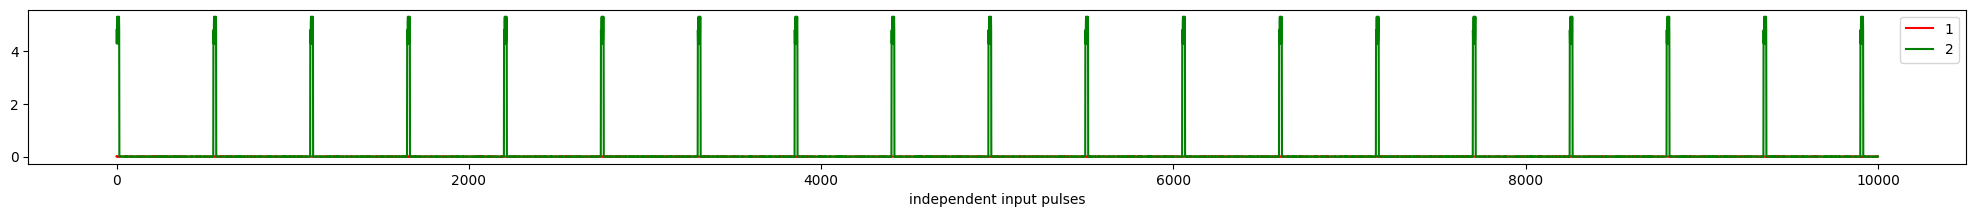

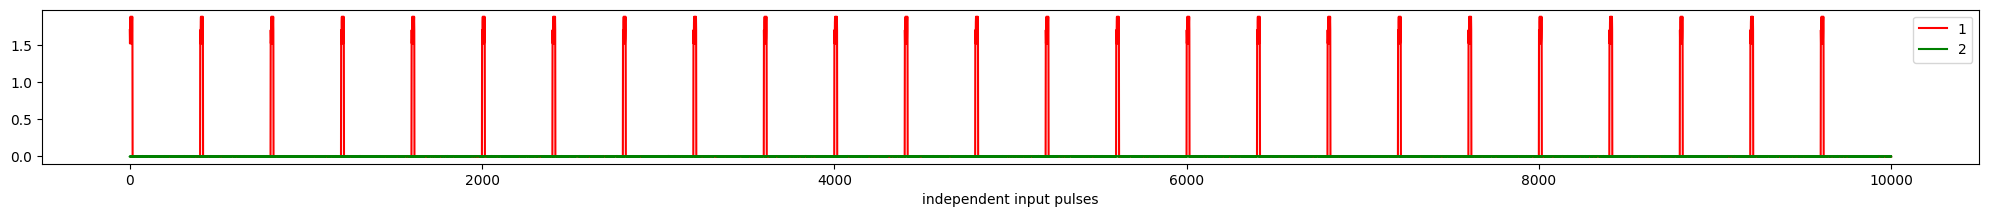

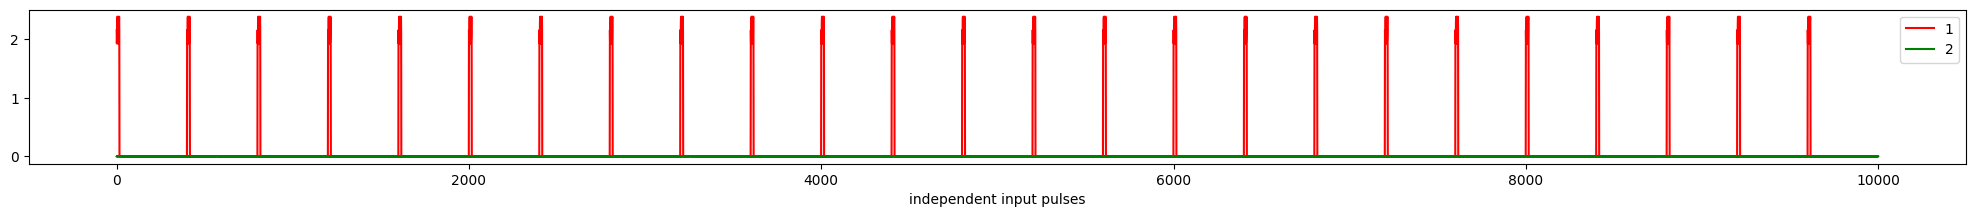

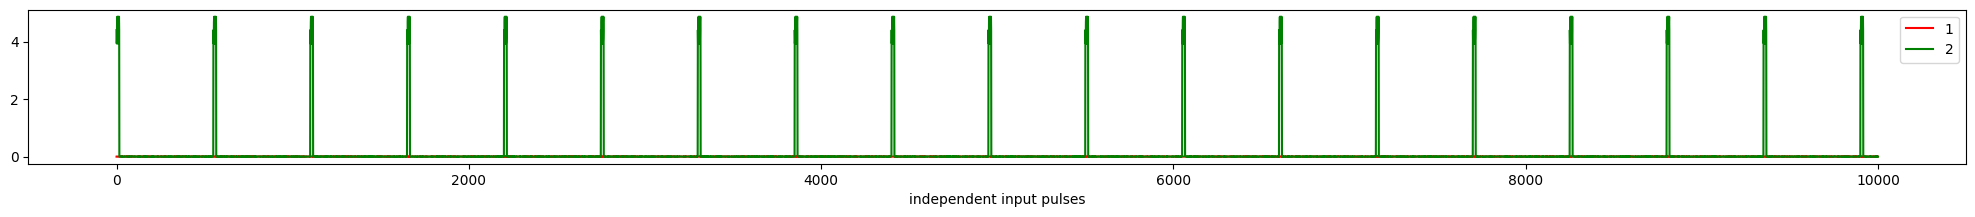

In [35]:
import matplotlib.pyplot as plt

time_l=[*range(idx)]
ci=0#len(time)//4
cf=len(time_l)//1

fig_x , fig_y = 25 , 2
clrs= 'rgbcmyk'

for i in pulse_train:
    plt.figure(figsize=(fig_x , fig_y))
    jdx=0
    for j in i:
        jdx+=1
        plt.plot(time_l[ci:cf],j[ci:cf], color=clrs[jdx-1], label=str(jdx))
    plt.legend()
    plt.xlabel("independent input pulses")
    # plt.ylim([0, ylim])
    # plt.savefig("independent"+str(jdx)+".jpg")
    plt.show()

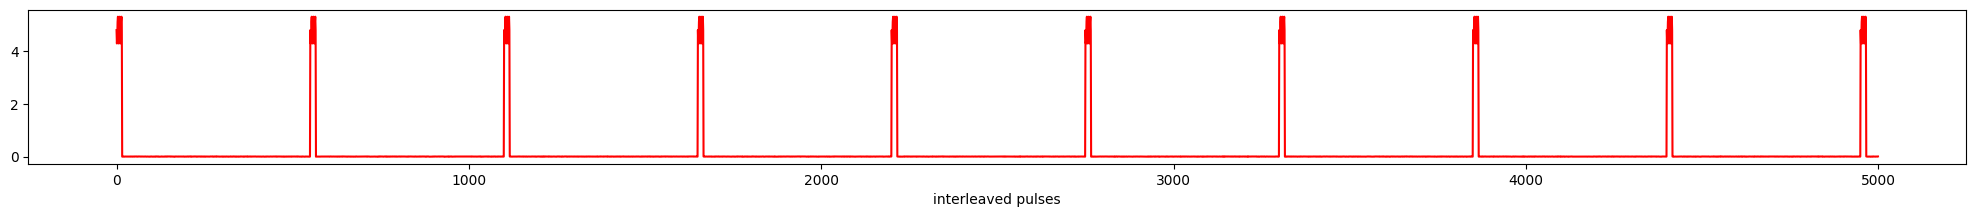

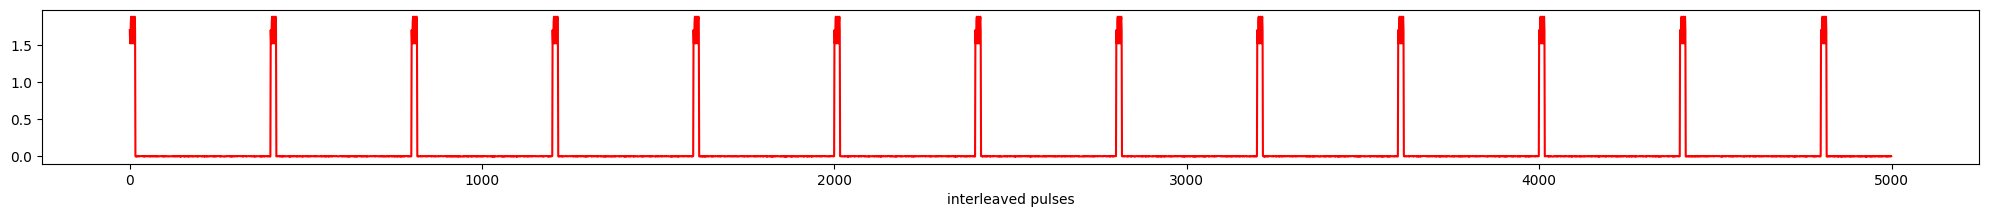

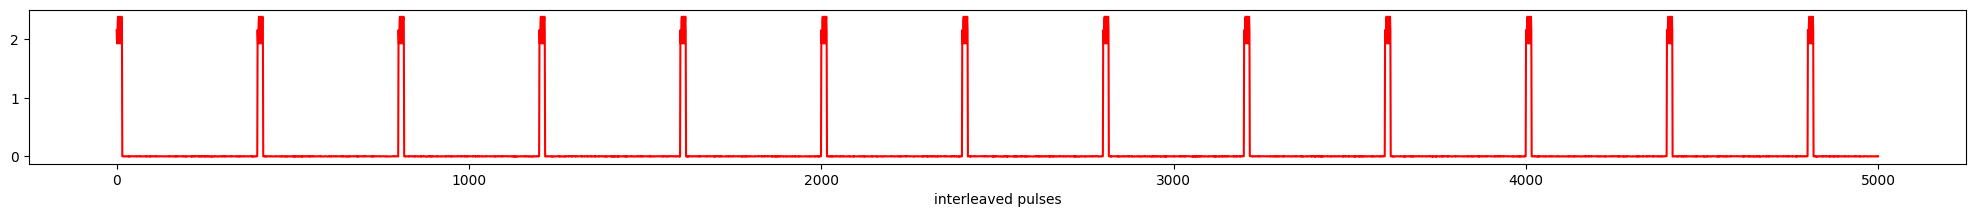

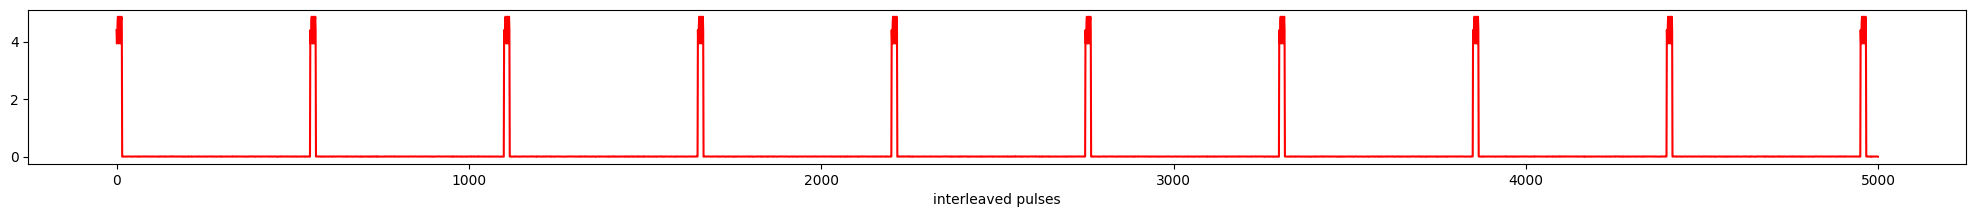

In [38]:
import matplotlib.pyplot as plt

time_l=[*range(idx)]
ci=0#len(time)//4
cf=len(time_l)//2

fig_x , fig_y = 25 , 2
clrs= 'rgbcmyk'


# for i in pulse_train_angles:
for i in pulse_train_f:
    plt.figure(figsize=(fig_x , fig_y))
    plt.plot(time_l[ci:cf],i[ci:cf], color=clrs[0])
    plt.xlabel("interleaved pulses")
    # plt.ylim([0, ylim])
    # plt.savefig("independent"+str(jdx)+".jpg")
    plt.show()

In [9]:
import pyfiglet
from rich import print as printf
 
title = pyfiglet.figlet_format('Hello', font='starwars')
printf(f'[white]{title}[/white]')

 __    __   _______  __       __        ______   
|  |  |  | |   ____||  |     |  |      /  __  \  
|  |__|  | |  |__   |  |     |  |     |  |  |  | 
|   __   | |   __|  |  |     |  |     |  |  |  | 
|  |  |  | |  |____ |  `----.|  `----.|  `--'  | 
|__|  |__| |_______||_______||_______| \______/  
                                                 

In [10]:
# def draw_rectangle(event,x,y,flags,param):
#     global pt_clicked
#     if event == cv2.EVENT_LBUTTONDOWN:
#         pt1 = (x,y)
#         pt_clicked.append(pt1)
#         cv2.circle(frame, center=pt1, radius=5, color=(0,0,255), thickness=-1)

# cv2.namedWindow('Test')
# cv2.setMouseCallback('Test', draw_rectangle) 

# pt_clicked=[]

# frame = np.zeros(img.shape, np.uint8)
# while True:
#     for i in radars:
#         radar_pos=(int(img.shape[1]//2+i.pos[0]),int(img.shape[0]//2+i.pos[1]))
#         radar_pos=(int(i.pos[0]),int(i.pos[1]))
#         heading_angle=int(math.degrees(math.atan2(airc_pos[1]-radar_pos[1],airc_pos[0]-radar_pos[0])))#+180
#         heading_noise_range=0
#         i.heading=random.randint(heading_angle-heading_noise_range,heading_angle+heading_noise_range)
#         cv2.circle(frame, radar_pos, 5, (255,0,0), -1)
#         cv2.line(frame, radar_pos, 
#                  (int(radar_pos[0]+(tmp_s_r*math.cos(math.radians(i.heading)))),
#                   int(radar_pos[1]+(tmp_s_r*math.sin(math.radians(i.heading))))), (0,0,255), 2)
#     cv2.imshow('Test', frame)
#     qk=cv2.waitKey(1) & 0xFF
#     if qk == ord('q'):
#         print(pt_clicked)
#         break
#     if qk == ord('r'):
#         pt_clicked=[]
#         frame = np.zeros(img.shape, np.uint8)
#     if qk == ord('s'):
#         print(pt_clicked)
# cv2.destroyAllWindows()

In [11]:
# def draw_rectangle(event,x,y,flags,param):
#     global pt_clicked
#     if event == cv2.EVENT_LBUTTONDOWN:
#         pt1 = (float(x),float(y))
#         pt_clicked.append(pt1)
#         cv2.circle(frame, center=(int(pt1[0]),int(pt1[1])), radius=5, color=(0,0,255), thickness=-1)

# cv2.namedWindow('Test')
# cv2.setMouseCallback('Test', draw_rectangle) 

# pt_clicked=[]

# frame = np.zeros(img.shape, np.uint8)
# while True:
#     cv2.imshow('Test', frame)
#     qk=cv2.waitKey(1) & 0xFF
#     if qk == ord('q'):
#         print(pt_clicked)
#         break
#     if qk == ord('r'):
#         pt_clicked=[]
#         frame = np.zeros(img.shape, np.uint8)
#     if qk == ord('s'):
#         print(pt_clicked)
# cv2.destroyAllWindows()

In [12]:
# frame = np.zeros((500,2000,3), np.uint8)
# while True:
#     cv2.imshow('Test', frame)
#     qk=cv2.waitKey(1) & 0xFF
#     if qk == ord('q'):
#         break
# cv2.destroyAllWindows()